# Normalized Inter-Class Variance (NICV) Analysis

## Imports

In [1]:
# tmp due to project re-structure

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.insert(0, '/home/lcastellazzi/MDM32/src/utils')
from preprocessing import TraceHandler
from nicv import nicv

## Compute NICV for each possible Device-Key configuration (for each key-byte)

### Get traces data

In [2]:
paths = ['/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs',
         '/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs',
         '/prj/side_channel/PinataTraces/CURR/D1-K3_50k_500MHz + Resampled at 168MHz.trs',
         '/prj/side_channel/PinataTraces/CURR/D2-K1_50k_500MHz + Resampled at 168MHz.trs',
         '/prj/side_channel/PinataTraces/CURR/D2-K2_50k_500MHz + Resampled at 168MHz.trs', 
         '/prj/side_channel/PinataTraces/CURR/D2-K3_50k_500MHz + Resampled at 168MHz.trs']

trace_handlers = [TraceHandler(path) for path in paths]

100%|██████████| 50000/50000 [00:21<00:00, 2306.43it/s]


100%|██████████| 16/16 [00:23<00:00,  1.50s/it]


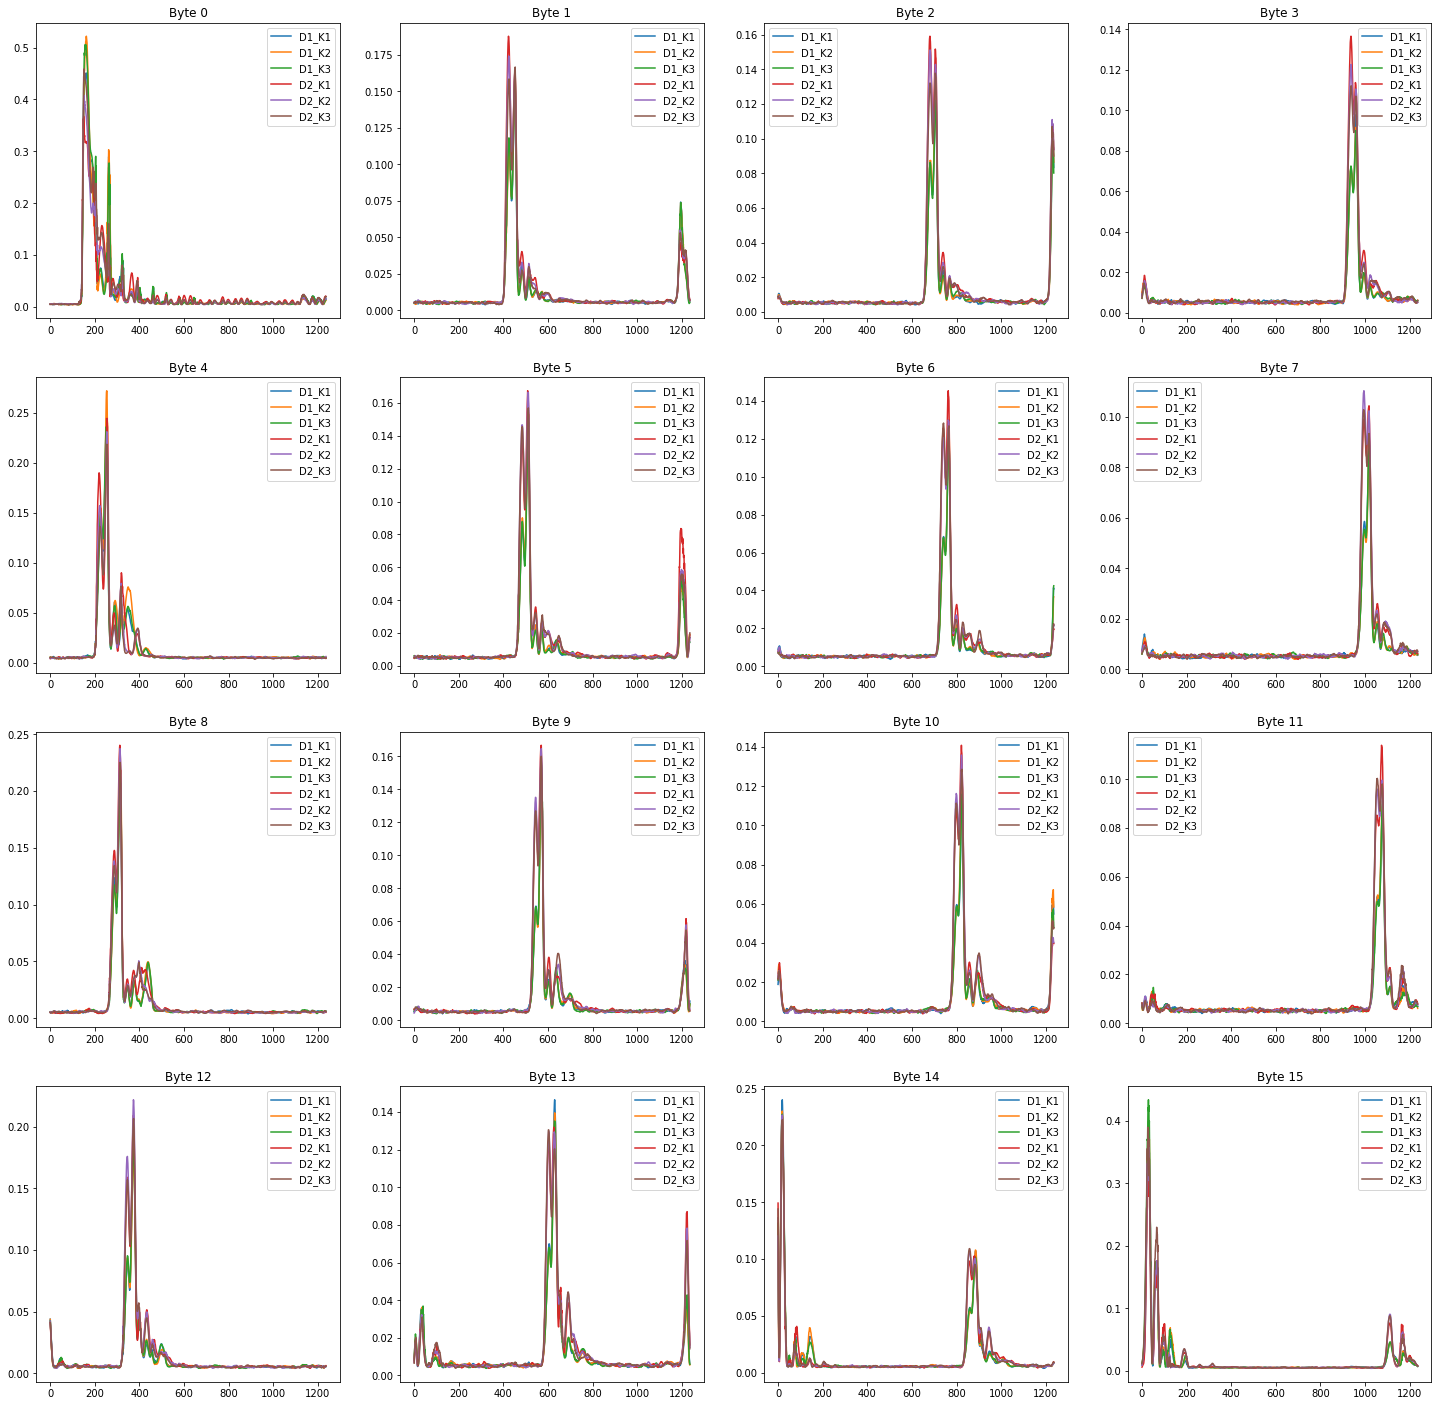

In [4]:
plot_labels = ['D1_K1', 
               'D1_K2', 
               'D1_K3', 
               'D2_K1', 
               'D2_K2', 
               'D2_K3']

figure, axis = plt.subplots(4, 4, figsize=(25,25))
x = 0

for b in tqdm(range(16)):
    
    y = b % 4
    
    for i, trace_handler in enumerate(trace_handlers):
        
        traces = trace_handler.get_traces()
        plaintexts = trace_handler.get_plaintexts()
        
        nicv_val = nicv(traces, plaintexts, b)
        
        axis[x, y].plot(nicv_val, label=plot_labels[i])
        axis[x, y].legend()
        axis[x, y].set_title(f'Byte {b}')
    
    if y == 3:
        x += 1

plt.show()

This result proves that considering different devices and key produces small changes in the leakages, even if the implementation of the encryption algorithm is the same.

Indeed, considering a single plot, the trend that is followed by the leakages of each Device-Key configuration is essentially the same, while the values of the leakages change.

This is true for each key-byte.

### Save the figure as PNG

In [5]:
figure.savefig('../../MDM32/notebooks/images/NICV_diff.png', bbox_inches='tight', dpi=600)

## Compute NICV for a single Device-Key configuration (for each key-byte) 

Two different set of traces, collected at two different times, are considered.

### Get traces data

In [6]:
paths = ['/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs',
         '/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz (NICV) + Resampled at 168MHz.trs']

trace_handlers = [TraceHandler(path) for path in paths]

100%|██████████| 50000/50000 [00:21<00:00, 2278.84it/s]


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


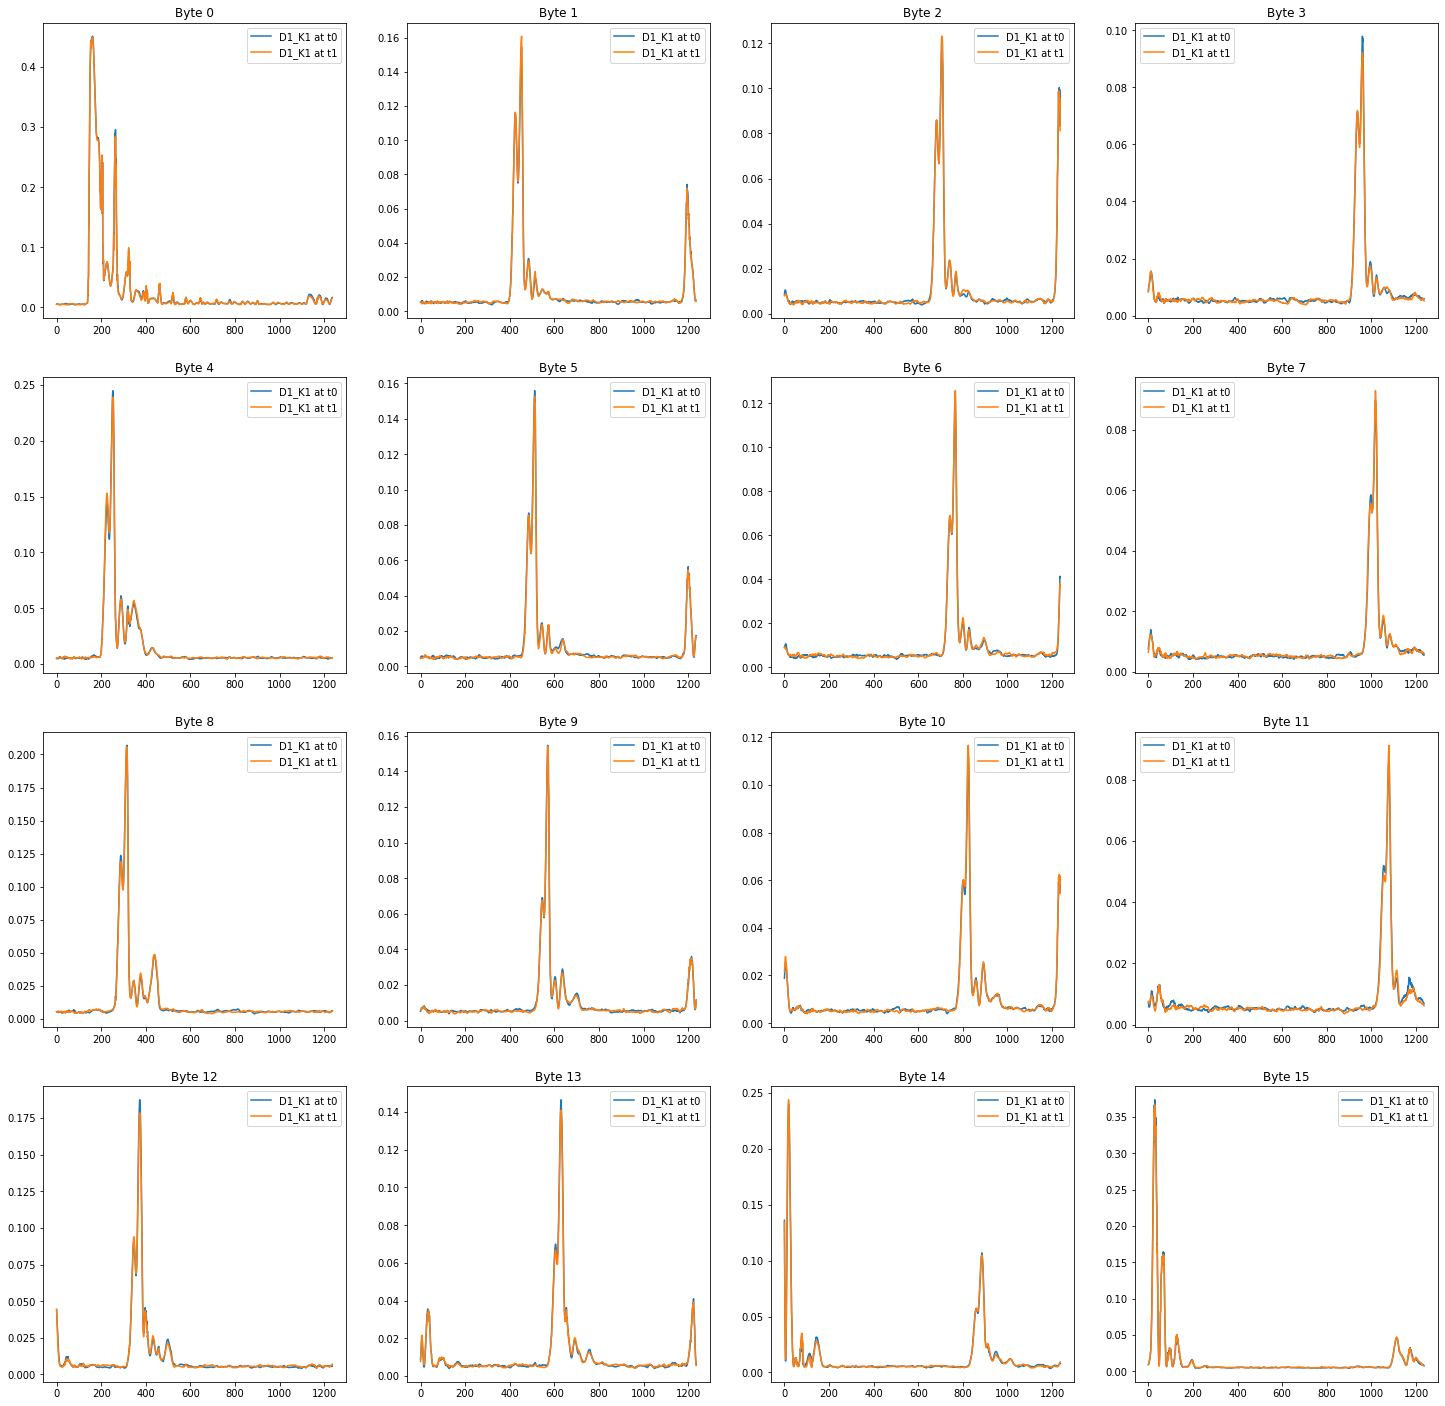

In [7]:
plot_labels = ['D1_K1 at t0', 
               'D1_K1 at t1']

figure, axis = plt.subplots(4, 4, figsize=(25,25))
x = 0

for b in tqdm(range(16)):
    
    y = b % 4
    
    for i, trace_handler in enumerate(trace_handlers):
        traces = trace_handler.get_traces()
        plaintexts = trace_handler.get_plaintexts()
        
        nicv_val = nicv(traces, plaintexts, b)
        
        axis[x, y].plot(nicv_val, label=plot_labels[i])
        axis[x, y].legend()
        axis[x, y].set_title(f'Byte {b}')
    
    if y == 3:
        x += 1

plt.show()

This result shows instead how the leakages are basically the same if only one Device-Key configuration is used.

Also in this case, this conclusion is true for each key-byte.

### Save the figure as PNG

In [8]:
figure.savefig('../../MDM32/notebooks/images/NICV_same.png', bbox_inches='tight', dpi=600)